<a href="https://colab.research.google.com/github/JohanSantanaGalvanJob/Chessman-Images/blob/main/ChessmanImage_JohanSantanaGalv%C3%A1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Johan Santana Galván

Importamos las librerías que vamos a usar.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import urllib.request
import zipfile
import cv2
import os
import glob
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

Esta es la URL que vamos a tomar de referencia

In [95]:
url = "/content/drive/MyDrive/Chessman_Images/Chessman-image-dataset/Chess"

Y estos son los tipos de subcarpetas que tenemos en el conjunto de datos

In [96]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'Bishop', 1: 'King', 2: 'Knight',
    3: 'Pawn', 4: 'Queen', 5: 'Rook'
}

Aquí podemos ver que usaremos el tamaño de la imagen a 64x64.

In [97]:
IMG_SIZE = 64

Este es nuestro método de entrenamiento, se cargan los datos de training en imágenes y se excluyen las que ya han sido seleccionadas para el test.

Debemos también readaptar el tamaño de las imágenes a 64x64 y con esto tenemos que tener en cuenta otra serie de variables:

dirname: directorio completo del que leer los datos

map_characters: variable de mapeo entre labels y personajes

selected_test_images: conjunto de nombres de archivo de las imágenes seleccionadas para el conjunto de prueba

verbose: si es True, muestra información de las imágenes cargadas

In [98]:
def load_train_set(dirname, map_characters, selected_test_images, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith('jpg') or
                  file.endswith('JPG') or file.endswith('jpeg') or file.endswith('png')
                  or file.endswith('php') or file.endswith('fcgi') or file.endswith('webp')]

        # Filtrar las imágenes seleccionadas para el conjunto de prueba
        images = [image for image in images if os.path.join(character, image) not in selected_test_images]
        if verbose:
            print("Leyendo {} imágenes encontradas de {} TRAIN".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)

    return np.array(X_train), np.array(y_train)

Este es nuestro método de test en el que se hace básicamente lo mismo que con train pero solamente seleccionamos el 20% de cada carpeta de imágenes. Esto se hace porque cada carpeta contiene un número de datos distinto. Por ejemplo la carpeta Bishop tiene 86 imágenes mientras que la Knight tiene 106. Además, las imágenes seleccionadas de test son aleatorias y luego en los de train NO deben coincidir de tal forma que están bien diferenciados

In [99]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    selected_images_count = {}  # Contador para el número de imágenes seleccionadas por carpeta
    reverse_dict = {v: k for k, v in map_characters.items()}

    selected_test_images = set()  # Conjunto para almacenar los nombres de archivo de las imágenes seleccionadas para el conjunto de prueba

    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith('jpg') or
                  file.endswith('JPG') or file.endswith('jpeg') or file.endswith('png')
                  or file.endswith('php') or file.endswith('fcgi') or file.endswith('webp')]
        if verbose:
            print("Leyendo {} imágenes encontradas de {} TEST".format(len(images), character))
        images_to_pick = max(1, int(len(images) * 0.2))  # Selecciona el 20% de las imágenes de la carpeta
        selected_images = random.sample(images, images_to_pick)
        selected_images_count[character] = len(selected_images)  # Guarda el número de imágenes seleccionadas
        for image_name in selected_images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_test.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_test.append(reverse_dict[character])
            selected_test_images.add(os.path.join(character, image_name))  # Agrega el nombre de archivo al conjunto de imágenes seleccionadas

    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
        print("Número de imágenes seleccionadas por carpeta:")
        for character, count in selected_images_count.items():
            print("{}: {}".format(character, count))

    return np.array(X_test), np.array(y_test), selected_test_images

Primero vamos a cargar los datos de test y luego los de train para que las imágenes sean completamente descartadas luego en el train. Después en el resultado veremos que test lee absolutamente todas las imágenes de las carpetas y se queda con el 20% de cada una. Y después Train se queda con el resto de imágenes.

In [100]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/content/drive/MyDrive/Chessman_Images/Chessman-image-dataset/Chess"

X_t, y_t, test_images = load_test_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS, test_images)

Leyendo 86 imágenes encontradas de Bishop TEST
Leyendo 76 imágenes encontradas de King TEST
Leyendo 106 imágenes encontradas de Knight TEST
Leyendo 107 imágenes encontradas de Pawn TEST
Leyendo 78 imágenes encontradas de Queen TEST
Leyendo 102 imágenes encontradas de Rook TEST
Leídas 109 imágenes de test
Número de imágenes seleccionadas por carpeta:
Bishop: 17
King: 15
Knight: 21
Pawn: 21
Queen: 15
Rook: 20
Leyendo 69 imágenes encontradas de Bishop TRAIN
Leyendo 61 imágenes encontradas de King TRAIN
Leyendo 85 imágenes encontradas de Knight TRAIN
Leyendo 86 imágenes encontradas de Pawn TRAIN
Leyendo 63 imágenes encontradas de Queen TRAIN
Leyendo 82 imágenes encontradas de Rook TRAIN


Vamos a realizar la permutación de las variables.

In [101]:
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

Asimismo, realizaremos la normalización de las imágenes.

In [102]:
# Preprocessing normalización de las imágenes
X = X / 255.0
X_t = X_t / 255.0

Ahora vamos a ver un ejemplo sencillo para ver las imágenes cargadas a la resolución que es.

In [103]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

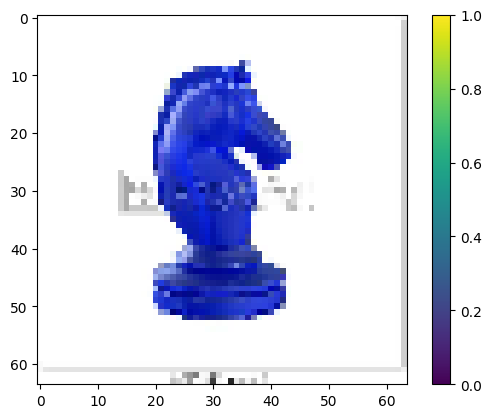

Knight
(64, 64, 3)


In [104]:
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

Aquí se definen algunas variables para que luego sean usadas como el número de clases (viene a ser el número de carpetas), las épocas, entre otros.

In [105]:
num_classes=6
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [106]:
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
y_t=keras.utils.to_categorical(y_t,num_classes)

In [53]:
X.shape

(446, 64, 64, 3)

In [54]:
y.shape

(446, 6)

Lo siguiente es cargar un modelo de los disponibles de keras (en este caso el relu) y se definen las distintas neuronas que vamos a usar en nuestro modelo. En ambos modelos he usado el Dropout.

Conv2D es una capa convolucional 2D que aplica 32 filtros (también conocidos como kernels) de tamaño 3x3 en la entrada. La entrada se espera que tenga una forma de (64, 64, 3), que es el tamaño de las imágenes de entrada en formato (altura, ancho, canales).

MaxPooling2D es una capa de agrupamiento 2D que reduce la dimensionalidad de la salida de la capa convolucional aplicando un filtro de agrupamiento.

Flatten se utiliza para aplanar la salida de la capa anterior en un vector unidimensional. Esto es necesario para conectar las capas densamente conectadas.

Dense es una capa densa con 500 neuronas (o unidades) y utiliza la función de activación ReLU.

In [107]:
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), data_format="channels_last", input_shape=(64, 64, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

Este es el mismo esquema pero ahora con la sigmoide y ejecutando uno u otro podemos hacer una comparativa simple de precisión en nuestro modelo (probando con este modelo no he conseguido ni de cerca un mejor resultado que con relu). De todas formas teorizo que aunque tocara valores como el dropout u otros, no conseguiría subir mucho la precisión del modelo, por lo que creo que no es el más idóneo para este caso concreto.

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=(64, 64, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(512, kernel_size=(3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [108]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 6, 6, 256)        

Vamos a pasar a medir con 19 épocas cuánto de accuracy podemos llegar a obtener en el contexto del modelo relu.

In [109]:
history=model.fit(X, y, epochs=19, validation_split = 0.2)

Epoch 1/19
12/12 [==============================] - 12s 875ms/step - loss: 1.9128 - accuracy: 0.2022 - val_loss: 1.7949 - val_accuracy: 0.1667
Epoch 2/19
12/12 [==============================] - 8s 692ms/step - loss: 1.7894 - accuracy: 0.1798 - val_loss: 1.7841 - val_accuracy: 0.2111
Epoch 3/19
12/12 [==============================] - 10s 813ms/step - loss: 1.7810 - accuracy: 0.1742 - val_loss: 1.7841 - val_accuracy: 0.2444
Epoch 4/19
12/12 [==============================] - 10s 850ms/step - loss: 1.7690 - accuracy: 0.2051 - val_loss: 1.7748 - val_accuracy: 0.2333
Epoch 5/19
12/12 [==============================] - 8s 692ms/step - loss: 1.7455 - accuracy: 0.2275 - val_loss: 1.7381 - val_accuracy: 0.2444
Epoch 6/19
12/12 [==============================] - 10s 829ms/step - loss: 1.7370 - accuracy: 0.2275 - val_loss: 1.7748 - val_accuracy: 0.2000
Epoch 7/19
12/12 [==============================] - 10s 868ms/step - loss: 1.6876 - accuracy: 0.2275 - val_loss: 1.6923 - val_accuracy: 0.4667
E

Lo siguiente sería crear las gráficas de precisión y de pérdida para comparar si hay una evolución en train o en val.

In [110]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

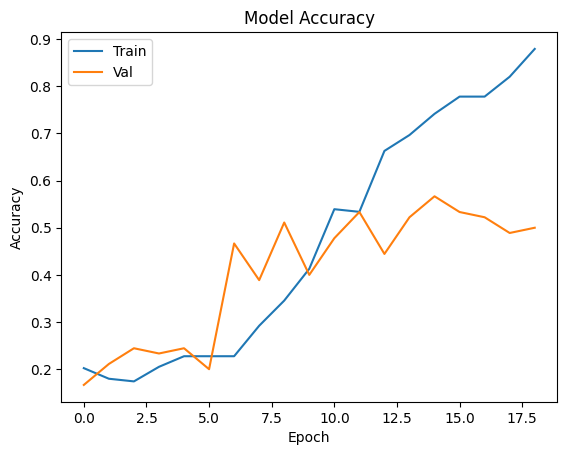

In [111]:
plot_acc(history)

En este caso, a más épocas, más se aumenta la precisión tanto en los valores de entrenamiento como en los de validación

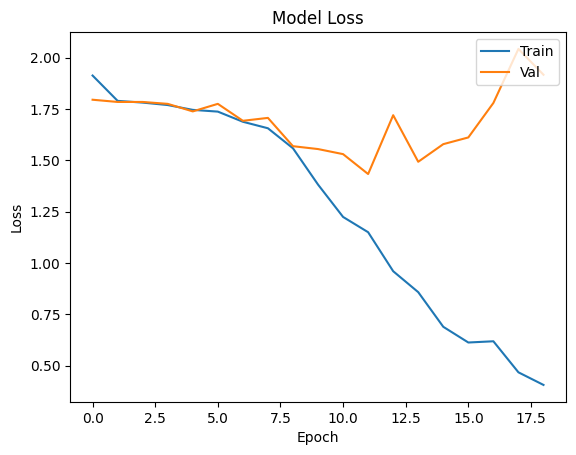

In [112]:
plot_loss(history)

Sin embargo en este caso vemos como a más épocas, menos pérdidas tenemos en los datos de entrenamiento pero más pérdida tenemos en validación

In [113]:
model.evaluate(X_t, y_t, batch_size=32, verbose=1)

4/4 [==============================] - 1s 136ms/step - loss: 2.5978 - accuracy: 0.4771


[2.597752332687378, 0.47706422209739685]

Ahora nos tocaría hacer el correspondiente predict después de haber conseguido realizar nuestro fit.

In [114]:
prediccion=model.predict(X_t, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test

4/4 [==============================] - 1s 223ms/step


In [ ]:
print(prediccion)
prediccion.shape

In [116]:
print(prediccion[0]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[0])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 18 clases.
print(predicho)
print(MAP_CHARACTERS[predicho]) # Acceso al diccionario para mostrar el nombre del personaje predicho.

[6.7799783e-01 2.7850163e-01 3.3689321e-05 9.6594176e-04 4.2463455e-02
 3.7519014e-05]
0
Bishop


In [ ]:
y_t.shape

Finalmente vamos a pintar una matriz de confusión en la que estableceremos cuántas imágenes realmente se han asignado bien a cada subcarpeta y cuántas son falsos positivos o falsos negativos.

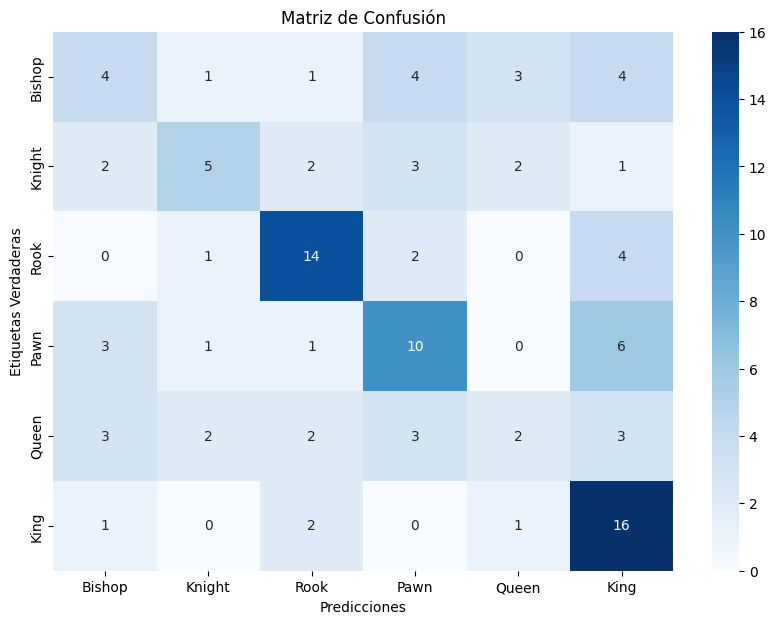

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos la matriz de confusión con los nombres de las piezas de ajedrez como etiquetas
etiquetas_personalizadas = ['Bishop', 'Knight', 'Rook', 'Pawn', 'Queen', 'King']
conf_matrix_df = pd.DataFrame(conf_matrix, index=etiquetas_personalizadas, columns=etiquetas_personalizadas)

# Creamos el mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')

# Añadimos etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')

# Mostramos el mapa de calor
plt.show()
